In [39]:
import pandas as pd
import numpy as np
import requests

In [42]:
useful_columns = [
    'merchant_name', 
    'user_id', 
    'email_time', 
    'order_number',
    'order_total_amount', 
    'order_shipping', 
    'order_tax',
    'order_subtotal',
    'order_total_qty',
    'product_description',
    'product_subtitle',
    'item_quantity',
    'item_price',
    'order_discount',
    'sku',
    'item_id',
]

response = requests.get('https://drive.google.com/u/1/uc?export=download&confirm=3fDP&id=122RIaJK5OuL4m9uIcUS4Zp8zZSzEe3Xd')
with open('Advent_Email_Receipt_Case_Study.csv', 'wb') as f:
    f.write(response.content)

data = pd.read_csv('Advent_Email_Receipt_Case_Study.csv', usecols=useful_columns)

ValueError: Usecols do not match columns, columns expected but not found: ['email_time', 'product_description', 'order_tax', 'item_id', 'order_subtotal', 'order_total_qty', 'product_subtitle', 'item_price', 'user_id', 'order_discount', 'order_total_amount', 'order_shipping', 'merchant_name', 'sku', 'order_number', 'item_quantity']

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422725 entries, 0 to 422724
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   merchant_name        422725 non-null  object 
 1   user_id              422725 non-null  object 
 2   order_number         405876 non-null  object 
 3   email_time           422725 non-null  object 
 4   order_total_amount   389198 non-null  float64
 5   order_shipping       233866 non-null  float64
 6   order_tax            326030 non-null  float64
 7   order_subtotal       333527 non-null  float64
 8   order_total_qty      422725 non-null  int64  
 9   product_description  422725 non-null  object 
 10  product_subtitle     210815 non-null  object 
 11  item_quantity        422725 non-null  int64  
 12  item_price           267838 non-null  float64
 13  order_discount       78465 non-null   float64
 14  sku                  42984 non-null   object 
 15  item_id          

In [4]:
data.describe()

,order_total_amount,order_shipping,order_tax,order_subtotal,order_total_qty,item_quantity,item_price,order_discount
count,389198.000000,233866.000000,326030.000000,333527.000000,422725.000000,422725.000000,267838.000000,78465.000000
mean,105.177639,1.997926,6.192552,110.486118,2.442318,1.010896,59.705796,25.869304
std,171.684749,4.642279,12.860951,169.667194,3.546670,0.145473,45.393039,35.959729
min,-2532.310000,-16.000000,-156.830000,-2448.410000,-1.000000,-1.000000,-695.000000,0.000000
25%,41.200000,0.000000,1.260000,44.140000,1.000000,1.000000,32.000000,8.800000
50%,69.500000,0.000000,3.710000,74.980000,1.000000,1.000000,49.990000,16.990000
75%,122.420000,0.000000,7.600000,129.950000,3.000000,1.000000,77.990000,32.520000
max,20127.290000,380.010000,1661.890000,18488.400000,160.000000,20.000000,1295.000000,1360.710000


In [5]:
import re

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'
targets = ['allbirds', 'crocs', 'dr martens', 'puma', 'skechers', 'steve madden', 'timberland', 'ugg']
data_cleaned = data.copy()
data_cleaned['product_description'] = data_cleaned['product_description'].str.lower()
data_cleaned['product_description'] = data_cleaned['product_description'].str.replace('[^0-9a-zA-Z ]+', '', regex=True)
data_focused = data_cleaned[data_cleaned['product_description'].str.contains('|'.join(targets), regex=True, flags=re.IGNORECASE)]
data_focused.loc[:,'vendor'] = None

for target in targets:
    data_focused.loc[:, 'vendor'] = data_focused[['product_description','vendor']].apply(lambda x: target if target in x.product_description else x.vendor, axis=1)
    
data_focused = data_focused[~(data_focused['vendor'] == None)]
data_focused = data_focused[(~data_focused['product_description'].str.contains('tshirt')) & ~data_focused['product_description'].str.contains('sock')]
data_focused[['vendor']].value_counts()

vendor      
skechers        144754
ugg              91676
crocs            64266
steve madden     44285
puma             39492
timberland       23862
dr martens       12784
allbirds           572
dtype: int64

In [7]:
data_focused[['user_id','order_number']].groupby('order_number').count().sort_values('user_id')

,user_id
order_number,
#1005,1
23430734CUS,1
23430697CUS,1
23430279CUS,1
2343026040,1
...,...
16,61
14,64
15,69


In [8]:
data_focused['email_time'].head()

0    2/22/2019 20:52
1    5/13/2018 18:30
2    5/13/2018 18:30
3     5/9/2020 21:55
4     6/26/2018 3:23
Name: email_time, dtype: object

In [9]:
data_formatted = data_focused.copy()
data_formatted['email_time'] = pd.to_datetime(data['email_time'])
data_formatted['bill_quarter'] = data_formatted['email_time'].dt.to_period(freq='Q')
data_formatted = data_formatted.sort_values('bill_quarter')
data_formatted[['email_time', 'bill_quarter']].head()

,email_time,bill_quarter
422724,2018-03-08 00:41:00,2018Q1
45479,2018-02-24 18:21:00,2018Q1
251747,2018-03-15 17:04:00,2018Q1
251722,2018-03-23 15:50:00,2018Q1
251721,2018-01-08 21:26:00,2018Q1


In [10]:
!python -m pip install seaborn
%matplotlib inline
from collections import Counter
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
customer_merchant_matrix = data_formatted[['user_id', 'vendor']].drop_duplicates()
customer_merchant_matrix['vendor'].value_counts()

skechers        72435
ugg             48514
crocs           36544
steve madden    25664
puma            22850
timberland      15365
dr martens       8388
allbirds          306
Name: vendor, dtype: int64

In [12]:
merchants = customer_merchant_matrix['vendor'].unique()

merchant_visits_adjacency_dictionary = {}

for merchant in merchants:
    merchant_visits_adjacency_dictionary[merchant] = [0 for merchant in merchants]

merchant_visits_adjacency = pd.DataFrame(merchant_visits_adjacency_dictionary, index=merchants)
merchant_visits_adjacency


,skechers,ugg,dr martens,puma,steve madden,crocs,timberland,allbirds
skechers,0,0,0,0,0,0,0,0
ugg,0,0,0,0,0,0,0,0
dr martens,0,0,0,0,0,0,0,0
puma,0,0,0,0,0,0,0,0
steve madden,0,0,0,0,0,0,0,0
crocs,0,0,0,0,0,0,0,0
timberland,0,0,0,0,0,0,0,0
allbirds,0,0,0,0,0,0,0,0


In [13]:
for index, row in merchant_visits_adjacency.iterrows():
    visiting_customers = customer_merchant_matrix.loc[customer_merchant_matrix['vendor'] == index, 'user_id']
    for column in merchant_visits_adjacency.columns:
        if index == column:
            merchant_visits_adjacency.loc[merchant_visits_adjacency.index == index, column] = None
        else:
            matching_visits = customer_merchant_matrix[(customer_merchant_matrix['vendor'] == column) & (customer_merchant_matrix['user_id'].isin(visiting_customers))]['user_id'].count()
            merchant_visits_adjacency.loc[merchant_visits_adjacency.index == index, column] = matching_visits

merchant_visits_adjacency

,skechers,ugg,dr martens,puma,steve madden,crocs,timberland,allbirds
skechers,NaN,8282.0,1091.0,4004.0,3874.0,7888.0,2639.0,39.0
ugg,8282.0,NaN,1842.0,3649.0,7010.0,5427.0,2910.0,67.0
dr martens,1091.0,1842.0,NaN,708.0,1238.0,874.0,577.0,16.0
puma,4004.0,3649.0,708.0,NaN,2400.0,2391.0,1405.0,28.0
steve madden,3874.0,7010.0,1238.0,2400.0,NaN,2577.0,1556.0,30.0
crocs,7888.0,5427.0,874.0,2391.0,2577.0,NaN,1537.0,42.0
timberland,2639.0,2910.0,577.0,1405.0,1556.0,1537.0,NaN,21.0
allbirds,39.0,67.0,16.0,28.0,30.0,42.0,21.0,NaN


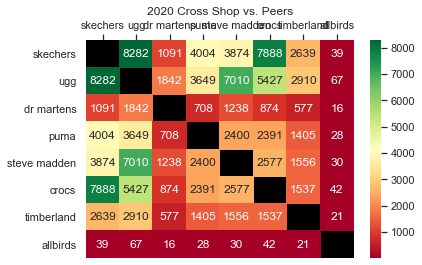

In [26]:
ax = sns.heatmap(merchant_visits_adjacency, annot=True, cmap='RdYlGn', fmt='g')
ax.xaxis.tick_top()
plt.title('2020 Cross Shop vs. Peers')
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white'})
plt.show()

In [38]:
q3_2020 = data_formatted[data_formatted['bill_quarter'] == pd.Period(freq='Q',quarter=3, year=2020)][['user_id', 'vendor']].drop_duplicates()
q3_tally = q3_2020.groupby('vendor').count()
q4_2020 = data_formatted[data_formatted['bill_quarter'] == pd.Period(freq='Q',quarter=4, year=2020)][['user_id', 'vendor']].drop_duplicates()
retention_matrix = q3_2020.merge(q4_2020, how='inner', on=['user_id', 'vendor'])
retention_tally = retention_matrix.groupby('vendor').count()
retention_totals = q3_tally.merge(retention_tally, how='left', left_index=True, right_index=True, suffixes=['_total', '_retained'])
retention_totals['retention_rate'] = retention_totals['user_id_retained'] / retention_totals['user_id_total']
retention_totals.sort_values('retention_rate', ascending=False)['retention_rate']

vendor
ugg             0.217419
allbirds        0.200000
skechers        0.118939
steve madden    0.100527
timberland      0.091510
dr martens      0.090387
crocs           0.082082
puma            0.064720
Name: retention_rate, dtype: float64

In [35]:
data2019_2020 = data_formatted[(data_formatted['bill_quarter'] >= pd.Period(freq='Q', year=2019, quarter=1)) & (data_formatted['bill_quarter'] < pd.Period(freq='Q', year=2021, quarter=1))][['user_id','vendor']].drop_duplicates()

vendor_loyal_customers = []

for target in targets:

    total_unique_customers = data2019_2020[data2019_2020['vendor'] == target]['user_id'].unique()
    total_unique_customers_count = total_unique_customers.shape[0]
    customer_vendors = data2019_2020[data2019_2020['user_id'].isin(total_unique_customers)].groupby('user_id').count()
    loyal_customers_count = customer_vendors[customer_vendors['vendor'] == 1]['vendor'].count()
    vendor_loyal_customers.append(loyal_customers_count / total_unique_customers_count)

vendor_loyalty = pd.DataFrame({'rate': vendor_loyal_customers}, index=targets)
vendor_loyalty.sort_values('rate', ascending=False)

,rate
skechers,0.759949
crocs,0.660312
puma,0.633000
ugg,0.625870
timberland,0.599652
allbirds,0.578947
dr martens,0.574298
steve madden,0.558355


In [17]:
data_formatted[data_formatted['vendor'] == 'allbirds'][['sku']]

,sku
41881,NaN
52535,NaN
28315,NaN
334036,NaN
277788,NaN
...,...
134459,NaN
134458,NaN
331861,NaN
204401,NaN


In [18]:
data_sku_tidied = data_formatted.copy()
data_sku_tidied['sku'] = data_sku_tidied[['sku', 'product_description']].apply(lambda x: x['product_description'] if pd.isnull(x['sku']) else x['sku'], axis=1)
unique_skus = data_sku_tidied[['vendor','sku']].drop_duplicates()
sku_totals = unique_skus.groupby('vendor').count()
sku_totals

,sku
vendor,
allbirds,363
crocs,14264
dr martens,3797
puma,15538
skechers,43960
steve madden,10309
timberland,7412
ugg,25279


In [19]:

popular_items = []

for target in targets:
    skus = data_sku_tidied[data_sku_tidied['vendor'] == target][['item_quantity','sku']]
    popular_skus = skus.groupby('sku').sum()
    popular_skus.sort_values('item_quantity', ascending=False,inplace=True)
    popular_items.append(popular_skus.iloc[0].name)

popular_skus_vendor = pd.DataFrame({ 'sku': popular_items}, index=targets )
popular_skus_vendor


,sku
allbirds,allbirds wool runner sneaker men
crocs,crocs womens classic clog
dr martens,dr martens womens luana combat boot
puma,puma
skechers,skechers performance
steve madden,steve madden
timberland,timberland pro mens
ugg,ugg classic ii genuine shearling lined short b...


In [20]:
data_sku_item_prices = data_sku_tidied[data_sku_tidied['sku'].isin(popular_skus_vendor['sku'])][['vendor','sku','item_quantity', 'item_price','bill_quarter']]
print(data_sku_item_prices.info())
data_sku_item_prices.dropna(inplace=True)
data_sku_item_prices['price_total'] = data_sku_item_prices['item_quantity'] * data_sku_item_prices['item_price']
data_sku_item_prices = data_sku_item_prices[['vendor','sku','price_total','bill_quarter']].groupby(['vendor', 'sku', 'bill_quarter']).mean()
print(data_sku_item_prices.info())
data_sku_item_prices.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9437 entries, 251708 to 10367
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype        
---  ------         --------------  -----        
 0   vendor         9437 non-null   object       
 1   sku            9437 non-null   object       
 2   item_quantity  9437 non-null   int64        
 3   item_price     4671 non-null   float64      
 4   bill_quarter   9437 non-null   period[Q-DEC]
dtypes: float64(1), int64(1), object(2), period[Q-DEC](1)
memory usage: 442.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 63 entries, ('allbirds', 'allbirds wool runner sneaker men', Period('2018Q4', 'Q-DEC')) to ('ugg', 'ugg classic ii genuine shearling lined short boot women', Period('2020Q4', 'Q-DEC'))
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price_total  63 non-null     float64
dtypes: float64(1)
memory usage: 1.0+ KB
None


price_total
vendor   sku                              bill_quarter             
allbirds allbirds wool runner sneaker men 2018Q4          95.000000
                                          2019Q1         -25.909091
                                          2019Q2          44.970000
crocs    crocs womens classic clog        2018Q1          34.990000
                                          2018Q2          31.584167

In [21]:
price_difference_totals = []

for target in targets:
    total = 0
    if target in data_sku_item_prices.index:
        total = data_sku_item_prices.loc[target].diff().dropna().sum()[0]
    price_difference_totals.append(total)

price_deltas = pd.DataFrame({'price_delta': price_difference_totals}, index=targets).sort_values('price_delta', ascending=False)
price_deltas

,price_delta
skechers,79.453750
ugg,20.619620
steve madden,12.020988
dr martens,7.831905
crocs,3.818571
timberland,0.000000
puma,-12.742624
allbirds,-50.030000


In [22]:
data_orders = data_formatted[['vendor','order_total_amount','order_number','bill_quarter']].drop_duplicates()
company_average_order = data_orders[['vendor', 'order_total_amount']].groupby('vendor').mean()
company_average_order.columns = ['order_average_size']
company_average_order.sort_values('order_average_size', ascending=False)

,order_average_size
vendor,
ugg,143.449344
timberland,130.539354
dr martens,123.657412
steve madden,121.194107
puma,82.055733
skechers,70.241938
allbirds,69.576419
crocs,51.741201


In [23]:
order_tallys = data_orders[['vendor','order_number','bill_quarter']].groupby(['vendor', 'bill_quarter']).count().groupby(['vendor']).mean()
order_tallys.columns = ['order_count']
order_tallys.sort_values('order_count', ascending=False)

,order_count
vendor,
skechers,10457.916667
ugg,6406.000000
crocs,4532.833333
steve madden,3204.916667
puma,2855.250000
timberland,1720.416667
dr martens,925.500000
allbirds,35.500000


In [25]:
stack_rank = company_average_order.merge(order_tallys, how='inner', left_index=True, right_index=True)
stack_rank['score'] = stack_rank['order_average_size'] * stack_rank['order_count']
stack_rank.sort_values('score', ascending=False,inplace=True)
stack_rank[['score']]


,score
vendor,
ugg,918936.496015
skechers,734584.338882
steve madden,388417.012380
crocs,234534.240127
puma,234289.632648
timberland,224582.080770
dr martens,114444.934795
allbirds,2469.962892


In [34]:
growth = []

data_orders = data_formatted[['vendor','order_total_amount','order_number','bill_quarter']].drop_duplicates()
company_average_order = data_orders[['vendor', 'order_total_amount', 'bill_quarter']].groupby(['vendor','bill_quarter']).mean()

for target in targets:
    total = 0
    if target in data_sku_item_prices.index:
        total = data_sku_item_prices.loc[target].pct_change().dropna().sum()[0]
    growth.append(total)

growth_deltas = pd.DataFrame({'growth_delta': growth}, index=targets).sort_values('growth_delta', ascending=False)
growth_deltas


,growth_delta
skechers,2.893831
ugg,0.479511
steve madden,0.414606
crocs,0.171234
dr martens,0.131227
timberland,0.000000
puma,-0.257882
allbirds,-4.008411
